# Human Activity Recognition

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Highlights from Data Description:
* 561 features
* Data is normalized and features are bound within [-1,1]

Therefore it is not necessary to scale the data; however, due to the number of features a method of dimensionality reduction must be implemented.

#### Import data as pandas dataframe, correctly assign feature names and target labels

In [2]:
X_names = pd.read_csv('UCI HAR Dataset/features.txt', sep='\s+', names=['id','feature'])
X_names = X_names['feature'].tolist()

X_train = pd.read_csv('UCI HAR Dataset/train/X_train.txt', sep='\s+',names=X_names)
X_test = pd.read_csv('UCI HAR Dataset/test/X_test.txt', sep='\s+', names=X_names)


label_map = {row.id: row.label for i, row in pd.read_csv('UCI HAR Dataset/activity_labels.txt', sep = '\s+', 
                                                         names=['id','label']).iterrows()}

y_train = pd.read_csv('UCI HAR Dataset/train/y_train.txt', sep='\s+', names=['activity_id'])
y_test = pd.read_csv('UCI HAR Dataset/test/y_test.txt', sep='\s+', names=['activity_id'])

y_train['activity']=y_train.activity_id.map(label_map)
y_test['activity']=y_test.activity_id.map(label_map)

C:\Users\alros\Anaconda2\lib\site-packages\pandas\io\parsers.py:678: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)
C:\Users\alros\Anaconda2\lib\site-packages\pandas\io\parsers.py:678: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


### Dealing with Duplicates
* There are duplicate labels, but this is not an issue since we are not going to be using the label names
* There are duplicate columns. This is likely due to the data being normalized. These columns will be dealt with automatically through dimensionality reduction.

#### Out of curiosity, let's take a look at the duplicate column labels

In [3]:
index = []
dup = []
for i in range(X_train.shape[1]):
    for j in range(X_train.shape[1]):
        if np.array_equal(X_train.iloc[:,i].values, X_train.iloc[:,j].values) and i!=j and i not in index and j not in index:
            index.append(i)
            dup.append((X_train.keys()[i],X_train.keys()[j]))
dup

[('tBodyAccMag-mean()', 'tBodyAccMag-sma()'),
 ('tBodyAccMag-std()', 'tGravityAccMag-std()'),
 ('tBodyAccMag-mad()', 'tGravityAccMag-mad()'),
 ('tBodyAccMag-max()', 'tGravityAccMag-max()'),
 ('tBodyAccMag-min()', 'tGravityAccMag-min()'),
 ('tBodyAccMag-sma()', 'tGravityAccMag-mean()'),
 ('tBodyAccMag-energy()', 'tGravityAccMag-energy()'),
 ('tBodyAccMag-iqr()', 'tGravityAccMag-iqr()'),
 ('tBodyAccMag-entropy()', 'tGravityAccMag-entropy()'),
 ('tBodyAccMag-arCoeff()1', 'tGravityAccMag-arCoeff()1'),
 ('tBodyAccMag-arCoeff()2', 'tGravityAccMag-arCoeff()2'),
 ('tBodyAccMag-arCoeff()3', 'tGravityAccMag-arCoeff()3'),
 ('tBodyAccMag-arCoeff()4', 'tGravityAccMag-arCoeff()4'),
 ('tGravityAccMag-mean()', 'tGravityAccMag-sma()'),
 ('tBodyAccJerkMag-mean()', 'tBodyAccJerkMag-sma()'),
 ('tBodyGyroMag-mean()', 'tBodyGyroMag-sma()'),
 ('tBodyGyroJerkMag-mean()', 'tBodyGyroJerkMag-sma()'),
 ('fBodyAccMag-mean()', 'fBodyAccMag-sma()'),
 ('fBodyBodyAccJerkMag-mean()', 'fBodyBodyAccJerkMag-sma()'),
 ('fB

#### Based on the label names, it does seem likely that the duplicate columns are produced due to normalization
As mentioned earlier, the duplicate columns do not need to be removed since applying dimensionality reduction methods will inherently take care of this.

### Dimensionality Reduction with PCA

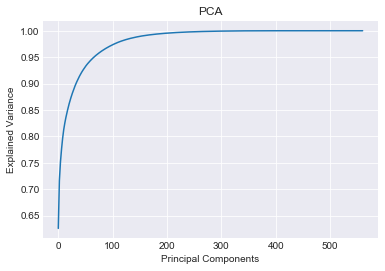

In [41]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

plt.plot(np.cumsum(pca.explained_variance_ratio_));
plt.title('PCA')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance');

### From the plot it is clear that:
* ~70 components account for 95% of the variance
* 100 components account for ~98% of the variance
* 200 components account for nearly 100% of the variance

### Visualize first 10 Principal Components and Make Performance Predictions

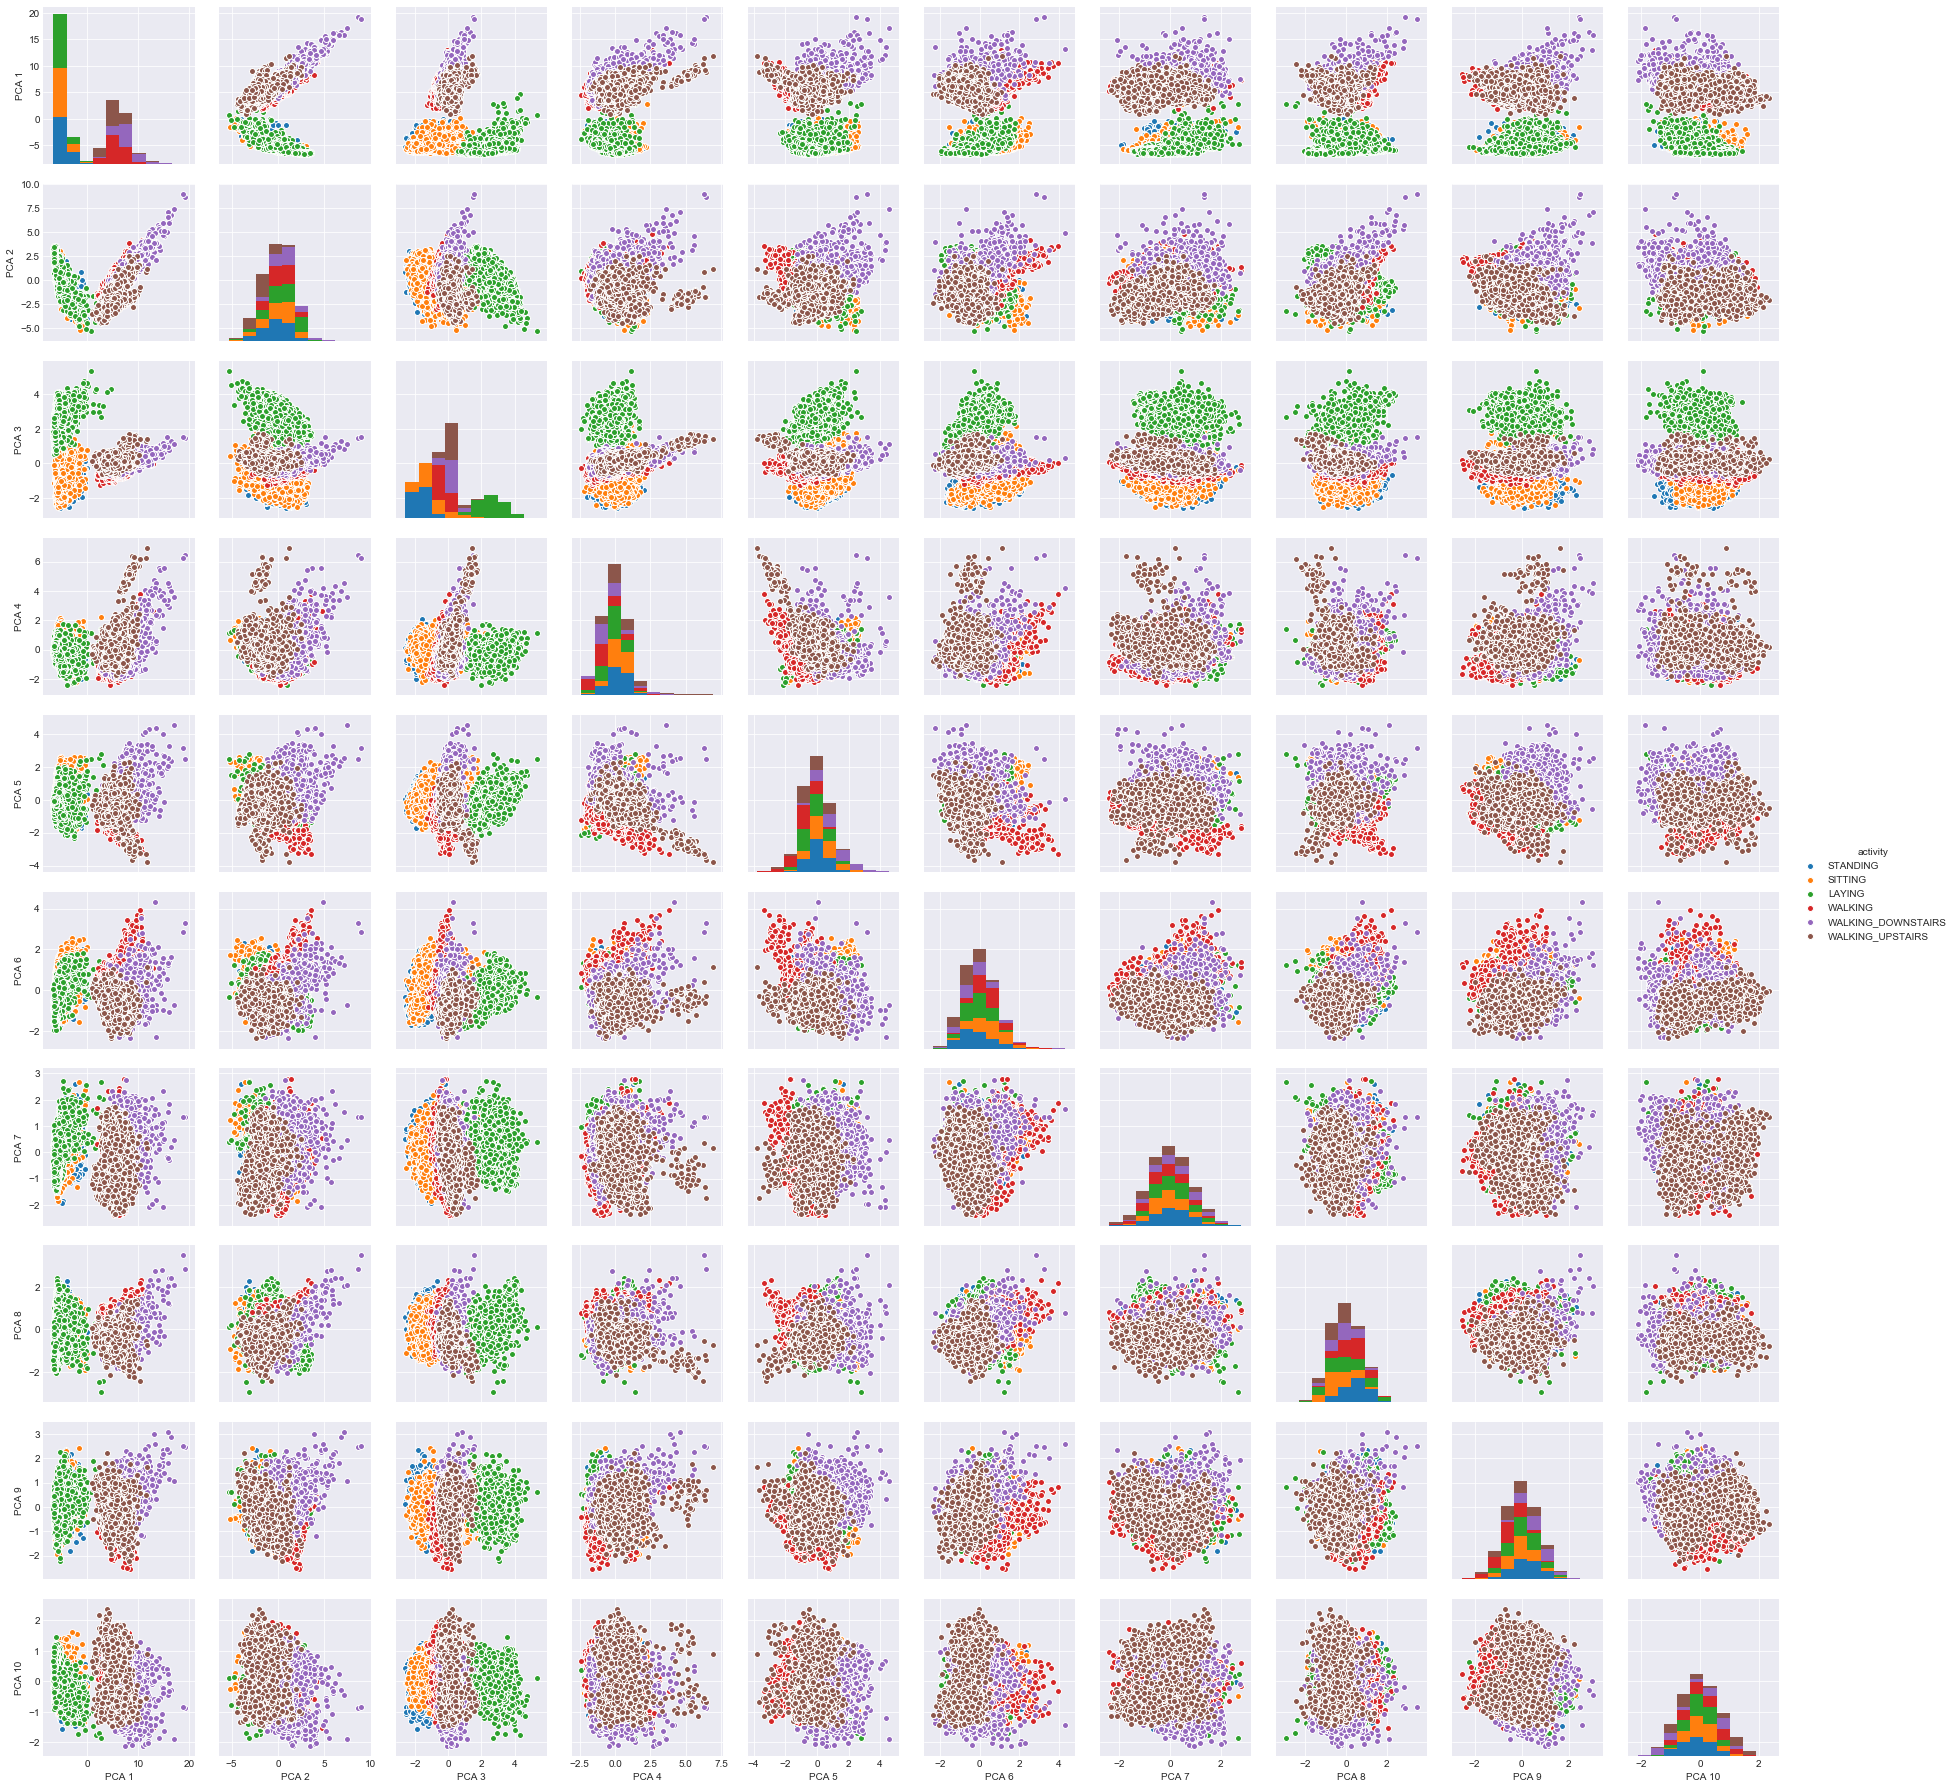

In [90]:
names =  list('PCA {}'.format(i) for i in range(1,11))
X_train_pca[:,:10].shape
PCA_10 = pd.DataFrame(X_train_pca[:,:10], columns=names)
PCA_10['activity'] = y_train.activity

sns.pairplot(PCA_10, hue='activity');

### From the plot it seems that:
* Laying will be the most easily classified action
* It may be difficult for classifiers to differentiate between standing and sitting
* It may be difficult for classifier to differentiate between the 3 walking actions

### Classifiers:
* LDA - [inspiration](https://www.researchgate.net/publication/309373991_Modeling_Human_Activity_Recognition_by_Dimensionality_Reduction_Approach) for this method
* Logistic Regression
* MLPClassifier
* KNeighborsClassifier